<a href="https://colab.research.google.com/github/Trickshotblaster/nn-practices/blob/main/TransformerV3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import requests
url = 'https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt'
raw_text = requests.get(url).text

In [2]:
train_amount = 0.9
train_text, val_text = raw_text[:int(len(raw_text) * train_amount)], raw_text[int(len(raw_text) * train_amount):]
train_text[:100]

'First Citizen:\nBefore we proceed any further, hear me speak.\n\nAll:\nSpeak, speak.\n\nFirst Citizen:\nYou'

In [3]:
vocab = set(raw_text)
vocab.add("<|UNK|>")
vocab = sorted(vocab)

stoi = {char:i for i, char in enumerate(vocab)}
itos = {i:char for i, char in enumerate(stoi)}
itos[stoi['<|UNK|>']]

'<|UNK|>'

In [4]:
class Tokenizer:
  def __init__(self, stoi, itos):
    self.stoi = stoi
    self.itos = itos
  def __len__(self):
    return len(self.stoi) - 1
  def encode(self, text):
    return [stoi.get(char, stoi['<|UNK|>']) for char in text]
  def decode(self, tokens):
    return "".join([itos.get(token, '<|UNK|>') for token in tokens])
tokenizer = Tokenizer(stoi, itos)
tokenizer.decode(tokenizer.encode("hello world ^}|%"))

'hello world <|UNK|><|UNK|><|UNK|><|UNK|>'

In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F

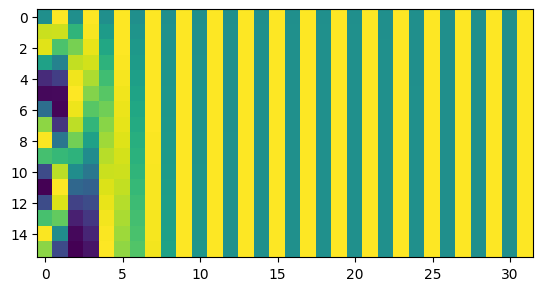

In [6]:
max_seq_len = 16
emb_dim = 32
import math
def create_positional_encoding_matrix(max_seq_len, emb_dim):
  mask = torch.zeros((max_seq_len, emb_dim))
  for pos in range(max_seq_len):
    for i in range(0, emb_dim, 2):
      mask[pos, i] = math.sin(pos/(10000 ** ((2*i)/emb_dim)))
      mask[pos, i+1] = math.cos(pos/(10000 ** ((2*(i+1))/emb_dim)))
  return mask
positional_encoding_matrix = create_positional_encoding_matrix(max_seq_len, emb_dim)
import matplotlib.pyplot as plt
plt.imshow(positional_encoding_matrix.numpy())

In [7]:
class MaskedMultiHeadAttention(nn.Module):
  def __init__(self, n_heads, emb_dim):
    super().__init__()
    assert emb_dim % n_heads == 0, "Embedding dimension must be divisible by head number"
    self.n_heads = n_heads
    self.emb_dim = emb_dim
    self.head_size = emb_dim // n_heads
    self.wq = nn.Linear(emb_dim, emb_dim)
    self.wk = nn.Linear(emb_dim, emb_dim)
    self.wv = nn.Linear(emb_dim, emb_dim)

    self.wo = nn.Linear(emb_dim, emb_dim)
  def forward(self, x):
    batch_size, seq_len, emb_dim = x.size()
    Q = self.wq(x).view(batch_size, seq_len, self.n_heads, self.head_size).transpose(1, 2)
    K = self.wk(x).view(batch_size, seq_len, self.n_heads, self.head_size).transpose(1, 2)
    V = self.wv(x).view(batch_size, seq_len, self.n_heads, self.head_size).transpose(1, 2)

    scaled_dot_product = (torch.matmul(Q, K.transpose(2, 3)))/(self.head_size**0.5)

    attn_mask = torch.triu(
        torch.ones(seq_len, seq_len),
        diagonal=1
    )
    attn_mask.masked_fill_(attn_mask==1, float('-inf'))

    attn_scores = torch.matmul(F.softmax(scaled_dot_product, dim=-1), V)
    attn_scores = attn_scores.view(batch_size, -1, self.n_heads * self.head_size)

    out = self.wo(attn_scores)

    return out # (batch_size, seq_len, emb_dim)
mha = MaskedMultiHeadAttention(8, emb_dim)
mha(torch.randn(1, max_seq_len, emb_dim))

tensor([[[-1.1079e-01, -5.2996e-02, -1.2542e-01,  2.0740e-02,  1.9853e-01,
          -4.7637e-03,  2.4665e-01,  1.7415e-01,  1.4261e-01, -9.9614e-02,
           9.4028e-02, -1.7790e-01, -7.4708e-04,  9.3606e-02,  1.5862e-01,
           1.4062e-01,  4.7044e-02,  1.2322e-01, -1.2288e-01,  1.0566e-01,
          -5.8030e-02, -3.2190e-01,  7.2645e-03, -5.5529e-02,  4.6495e-03,
           1.0663e-01,  2.0339e-02,  6.5438e-03,  1.3645e-01,  3.1781e-02,
           1.1376e-01,  4.0381e-02],
         [-1.0643e-01, -4.3847e-02, -1.2161e-01, -4.5406e-03,  1.7211e-01,
          -5.9603e-02,  2.0274e-01,  1.6685e-01,  8.2365e-02, -1.1966e-01,
           3.2123e-02, -1.9022e-01, -2.4701e-02,  7.1272e-02,  1.1387e-01,
           1.3588e-01,  1.6969e-04,  1.6315e-01, -6.8856e-02,  5.4099e-02,
          -7.3840e-02, -3.1247e-01,  1.9836e-02, -7.9970e-02,  5.0794e-02,
           1.1727e-01,  7.7811e-02,  1.2638e-02,  6.2088e-02,  8.2456e-02,
           4.1957e-02,  4.6338e-02],
         [-5.0011e-02, -4.

In [8]:
class MLP(nn.Module):
  def __init__(self, in_size, hidden_size, out_size):
    super().__init__()
    self.l1 = nn.Linear(in_size, hidden_size)
    self.l2 = nn.Linear(hidden_size, out_size)
    self.act = nn.GELU()
  def forward(self, ins):
    hidden = self.act(self.l1(ins))
    return self.act(self.l2(hidden))

In [9]:
class TransformerBlock(nn.Module):
  def __init__(self, n_heads, emb_dim):
    super().__init__()
    self.layernorm = nn.LayerNorm(emb_dim)
    self.n_heads = n_heads
    self.emb_dim = emb_dim
    self.MHA = MaskedMultiHeadAttention(n_heads, emb_dim)
    self.MLP = MLP(emb_dim, emb_dim * 4, emb_dim)
  def forward(self, ins):
    residual = ins.clone()
    attention_result = self.MHA(ins)
    attention_result += residual
    normalized_attention_result = self.layernorm(attention_result)
    residual2 = normalized_attention_result.clone()
    MLP_out = self.MLP(normalized_attention_result)
    MLP_out += residual2
    out = self.layernorm(MLP_out)
    return out
tb = TransformerBlock(8, emb_dim)
tb(torch.randn(1, max_seq_len, emb_dim))

tensor([[[-1.5759e+00, -1.1383e-01,  2.9037e-02, -1.1736e+00, -4.0735e-01,
           9.9353e-01, -1.2308e+00, -1.0696e+00, -3.1856e-01,  2.3106e-01,
          -4.2182e-02, -3.6915e-01, -1.5488e-03,  9.4527e-01, -3.5165e-01,
          -1.5788e+00,  3.0776e-01,  2.3586e+00,  5.7407e-01,  4.4814e-01,
           5.9529e-01,  1.5893e+00,  6.3104e-01,  5.5573e-02,  9.0289e-01,
           2.2705e+00, -6.8008e-01, -7.0277e-01,  3.7105e-01, -1.7777e+00,
          -6.3197e-03, -9.0328e-01],
         [ 4.5948e-01,  1.5005e+00, -1.0136e+00,  1.3872e+00,  1.0322e+00,
          -1.5098e+00,  1.8345e+00, -2.8755e-01,  4.7084e-02,  1.9839e+00,
          -1.4357e+00, -8.3122e-01,  5.3579e-01, -6.0059e-01,  2.7053e-01,
          -7.4930e-01,  5.2869e-02,  1.0591e+00, -4.8589e-01, -1.3277e+00,
           1.0687e-01, -6.4987e-01,  1.3837e-01,  9.7774e-01, -8.4478e-02,
          -4.6687e-01, -7.8971e-01,  1.1028e+00, -7.4115e-01, -2.1027e+00,
           4.9262e-01,  9.4646e-02],
         [ 1.5239e+00, -1.

In [21]:
class GPT(nn.Module):
  def __init__(self, n_heads, emb_dim, max_seq_len, n_blocks, tokenizer):
    super().__init__()
    self.n_heads = n_heads
    self.emb_dim = emb_dim
    self.max_seq_len = max_seq_len
    self.n_blocks = n_blocks
    self.tokenizer = tokenizer
    self.layernorm = nn.LayerNorm(emb_dim)
    self.emb = nn.Embedding(len(tokenizer) + 1, emb_dim)
    self.pos_encoding_matrix = create_positional_encoding_matrix(max_seq_len, emb_dim).to(device)
    self.decoder_stack = nn.ModuleList([
        TransformerBlock(n_heads, emb_dim)
        for _ in range(n_blocks)
    ])

    self.logits_layer = nn.Linear(emb_dim, len(tokenizer)+1)
  def forward(self, ins):
    embedding = self.emb(ins)
    pos_encoding_indices = torch.arange(ins.shape[1]).to(device) # seq_len

    x = embedding
    x += self.pos_encoding_matrix[pos_encoding_indices]

    for decoder in self.decoder_stack:
      x = decoder(x)

    x = self.layernorm(x)
    logits = self.logits_layer(x)
    return logits
  @torch.no_grad()
  def generate(self, text, length=10):
    out = ""
    for x in range(length):
      encodings = torch.tensor(self.tokenizer.encode(text + out)).to(device)
      seq_len = len(encodings)
      if seq_len > self.max_seq_len:
        encodings = encodings[len(encodings) - self.max_seq_len:]
      tokens = encodings.view(1, -1)
      logits = self.forward(tokens)[0, -1, :] # logits for last char
      probs = F.softmax(logits, dim=-1)
      selection_index = torch.multinomial(probs, num_samples=1)
      out += self.tokenizer.decode([selection_index.item()])
    return out

In [22]:
max_seq_len = 10
emb_dim = 32
n_heads = 8
n_blocks = 8

lr = 0.001
batch_size = 64
max_epochs = 1

log_period = 100

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')


myGPT = GPT(n_heads, emb_dim, max_seq_len, n_blocks, tokenizer)
myGPT = myGPT.to(device)
print("Total params:", sum(p.numel() for p in myGPT.parameters()))
if torch.cuda.is_available():
  myGPT = torch.compile(myGPT)
optim = torch.optim.AdamW(myGPT.parameters(), lr=lr)

Total params: 105474


In [18]:
def generate_dataset(max_seq_len, tokens):
  context_x = tokens[:max_seq_len]
  context_y = tokens[1:max_seq_len+1]
  x_examples = [context_x]
  y_examples = [context_y]
  for token, next in zip(tokens[max_seq_len:], tokens[max_seq_len+1:]):
    context_x = context_x[1:]
    context_x.append(token)
    context_y = context_y[1:]
    context_y.append(next)
    x_examples.append(context_x)
    y_examples.append(context_y)
  return torch.tensor(x_examples).long().to(device), torch.tensor(y_examples).to(device)
tokenized_train_data = tokenizer.encode(train_text)
Xtr, Ytr = generate_dataset(max_seq_len, tokenized_train_data)
tokenized_test_data = tokenizer.encode(val_text)
Xte, Yte = generate_dataset(max_seq_len, tokenized_test_data)
tokenizer.decode(Xtr[0].cpu().numpy()), tokenizer.decode(Ytr[0].cpu().numpy())

('First Citi', 'irst Citiz')

In [23]:
train_len = len(Xtr) - 1
max_steps = (train_len // batch_size) * max_epochs
for step in range(1000): # max_steps
  batch_indices = torch.randint(0, train_len, (batch_size,)).to(device)
  x_batch = Xtr[batch_indices]
  y_batch = Ytr[batch_indices].view(-1)

  logits = myGPT(x_batch)
  logits = logits.view(-1, logits.size(-1))
  loss = F.cross_entropy(logits, y_batch)
  optim.zero_grad()
  loss.backward()
  optim.step()

  if step % log_period == 0:
    print("Step", str(step) + ", loss:", loss.item())

Step 0, loss: 4.401139259338379
Step 100, loss: 2.575706720352173
Step 200, loss: 1.4283852577209473
Step 300, loss: 0.576152503490448
Step 400, loss: 0.4399939179420471
Step 500, loss: 0.30750858783721924
Step 600, loss: 0.2904627025127411
Step 700, loss: 0.2714124023914337
Step 800, loss: 0.2468138486146927
Step 900, loss: 0.24174949526786804


In [27]:
print(myGPT.generate("ROMEO:", length=100))

e, he wonra, il! nor,
To tog bulwepak?
RUKI: th' whesd to anur dadp to isst fon whend hetiin, achis:
